In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML
import numpy as np

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
# read images from directory as tensors
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    # specify the directory that contains the images
    'PlantVillage',
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 16011 files belonging to 10 classes.


2024-07-31 13:14:18.003380: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-07-31 13:14:18.003400: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2024-07-31 13:14:18.003408: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2024-07-31 13:14:18.003426: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-07-31 13:14:18.003437: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [4]:
# get the class name form tenser dataset (subdirectories) in the directory (PlantVillage)
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [5]:
# the length of the dataset is the number of batches with the specified batch size (32)
len(dataset)

501

In [6]:
len(dataset)*BATCH_SIZE

16032

2024-07-31 13:14:18.285689: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


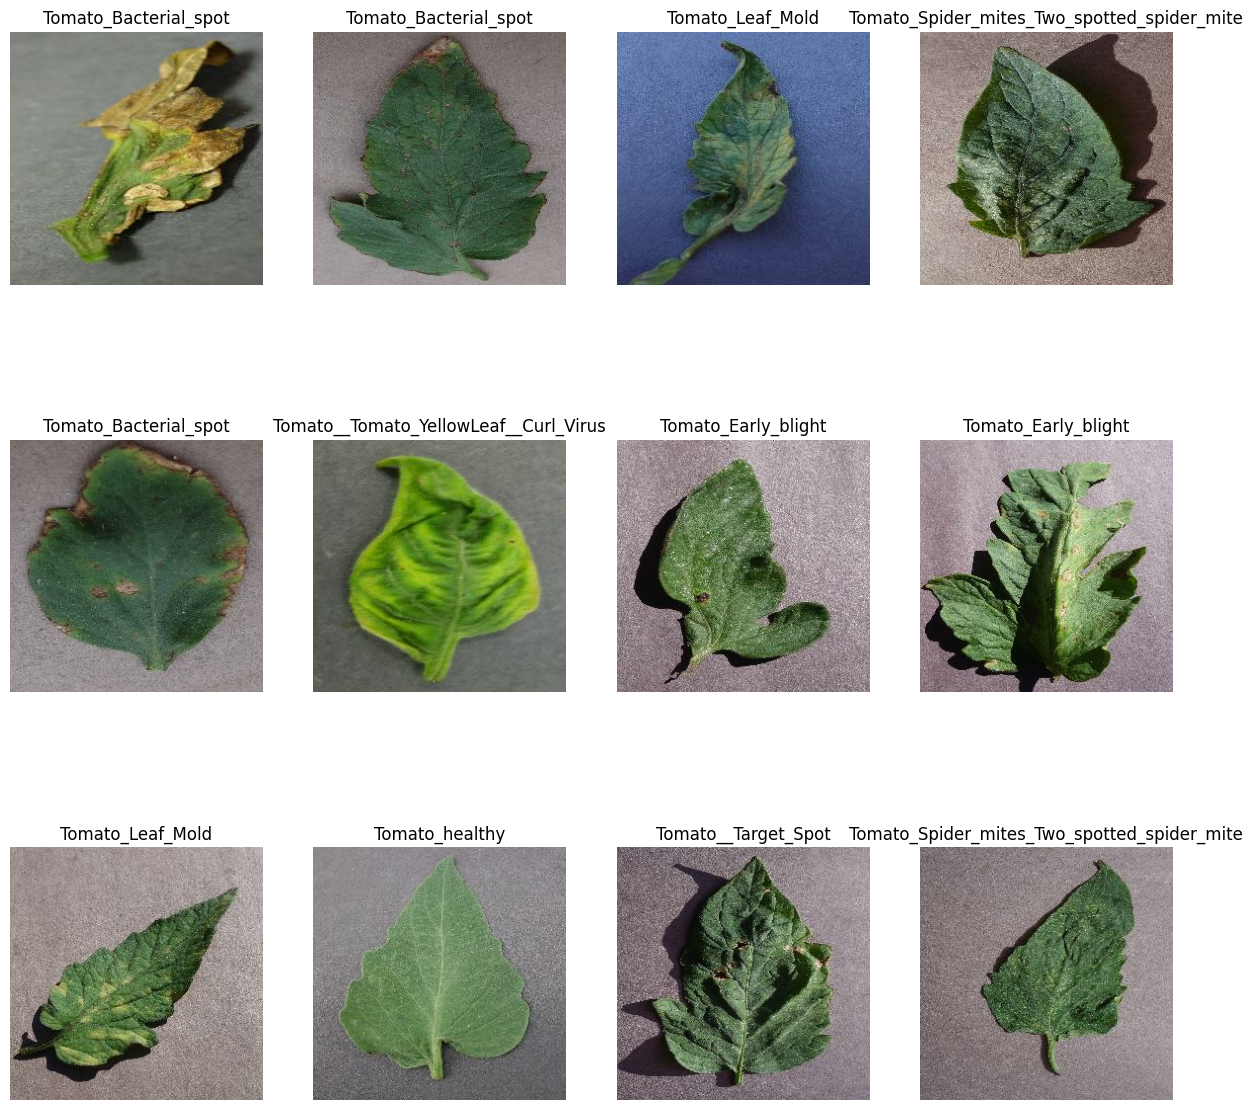

In [7]:
# show the first 12 images and their labels from the dataset
plt.figure(figsize=(15, 15))
for images, labels in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(images[i].numpy().astype('uint8'))
        plt.title(class_names[labels[i]])
        plt.axis('off')

In [8]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [9]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [10]:
len(train_ds)

400

In [11]:
len(val_ds)

50

In [12]:
len(test_ds)

51

In [13]:
# cache, shuffle, and prefetch the dataset for better performance
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [14]:
# creating the layers of the preprocessing 

# Build the rescaling and resizing layer for the model to ensure the input images are of the same size
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    # multiplying each pixel value by 1/255
    layers.Rescaling(1./255),
])

# Build data augmentation layer to prevent overfitting
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.1),
    # it work when removing the RandomZoom layer with input spsecified whay???
    # when changing the layers.RandomRotation(0.2) and layers.RandomZoom(0.1) it works
    # need check the documentation
    layers.RandomZoom(0.1),
])

In [15]:
# building CNN model
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(len(class_names), activation='softmax'),
])

model.build(input_shape=(BATCH_SIZE, *input_shape))

/Users/hneen/miniconda3/envs/tensorflow/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [16]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 10)               │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 184,202 (719.54 KB)

 Trainable params: 184,202 (719.54 KB)

 Non-trainable params: 0 (0.00 B)

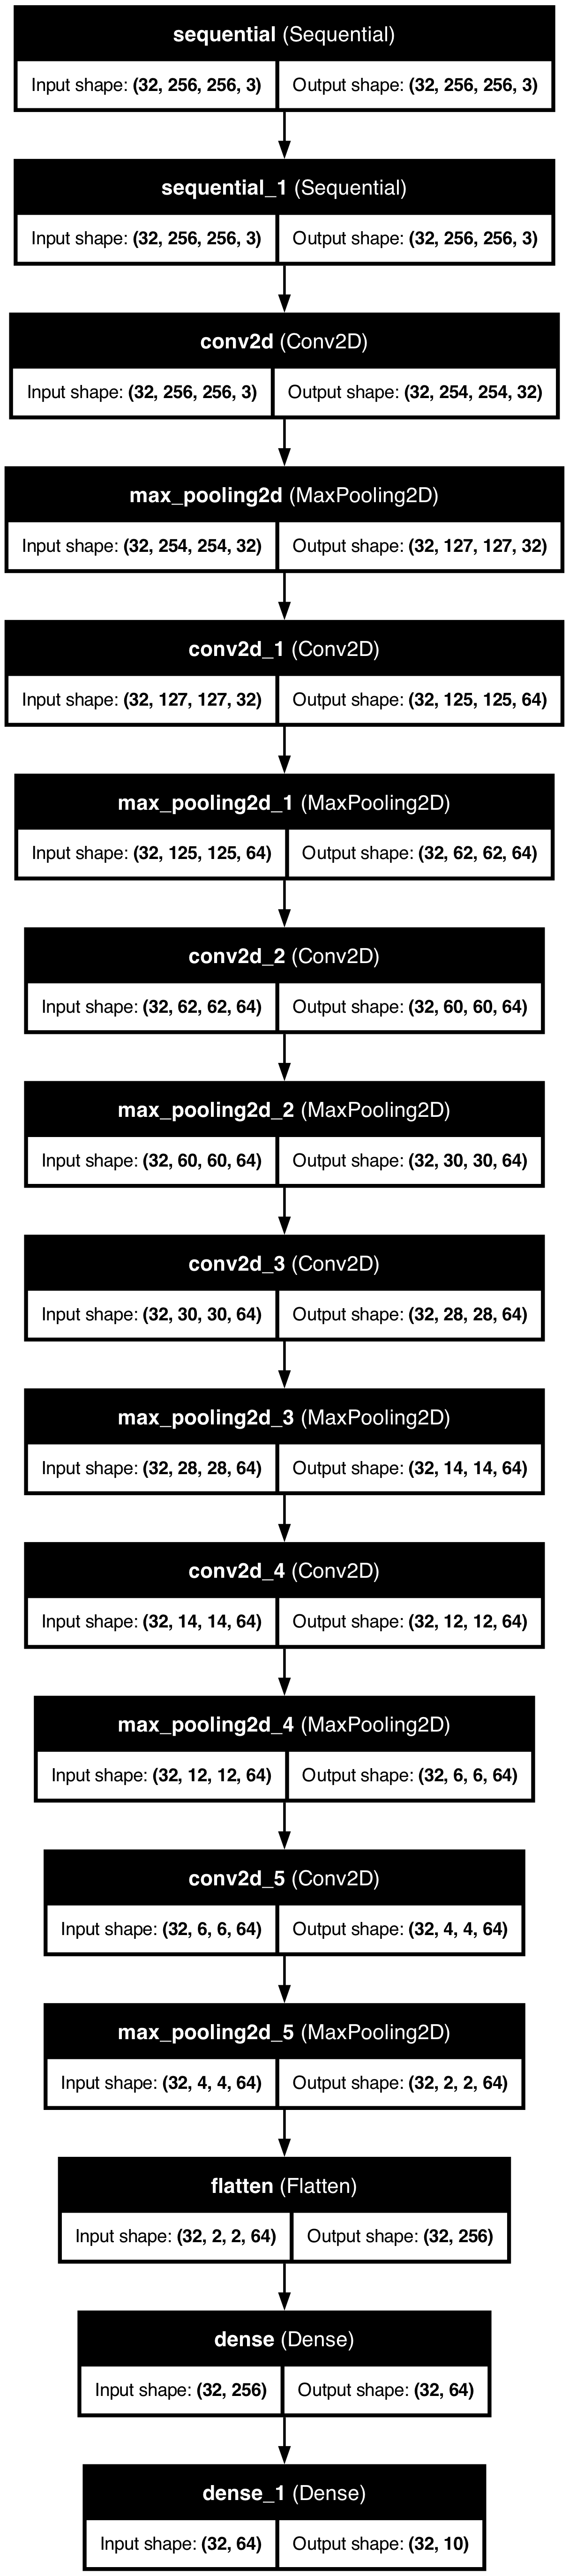

In [17]:
import pydot_ng as pydot
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model_diagram.png', show_shapes=True, show_layer_names=True)

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history  = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size = BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50


2024-07-31 13:14:21.649848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2024-07-31 13:14:32.104971: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 499 of 10000
2024-07-31 13:14:32.181928: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-31 13:14:32.282846: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.2896 - loss: 1.9535

2024-07-31 13:16:36.143263: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 325 of 10000
2024-07-31 13:16:42.435249: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-31 13:16:42.754172: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


400/400 ━━━━━━━━━━━━━━━━━━━━ 150s 343ms/step - accuracy: 0.2899 - loss: 1.9530 - val_accuracy: 0.5150 - val_loss: 1.3942
Epoch 2/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 109s 273ms/step - accuracy: 0.5666 - loss: 1.2630 - val_accuracy: 0.6237 - val_loss: 1.0890
Epoch 3/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 102s 255ms/step - accuracy: 0.6806 - loss: 0.9175 - val_accuracy: 0.6394 - val_loss: 1.0936
Epoch 4/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 104s 259ms/step - accuracy: 0.7674 - loss: 0.6844 - val_accuracy: 0.7056 - val_loss: 0.9596
Epoch 5/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 117s 291ms/step - accuracy: 0.8166 - loss: 0.5354 - val_accuracy: 0.7425 - val_loss: 0.8670
Epoch 6/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 109s 273ms/step - accuracy: 0.8578 - loss: 0.4173 - val_accuracy: 0.6994 - val_loss: 1.1627
Epoch 7/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 277ms/step - accuracy: 0.8748 - loss: 0.3535 - val_accuracy: 0.7294 - val_loss: 1.0622
Epoch 8/50
400/400 ━━━━━━━━━━━━━━━━━━━━ 127s 318ms/step - accuracy: 0.8919 - loss: 0.31

In [20]:
# score = model.evaluate(test_ds, batch_size=BATCH_SIZE)
score = model.evaluate(test_ds)

2024-07-31 14:48:18.001651: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:9: Filling up shuffle buffer (this may take a while): 420 of 10000
2024-07-31 14:48:20.774892: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.
2024-07-31 14:48:21.121743: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


51/51 ━━━━━━━━━━━━━━━━━━━━ 24s 91ms/step - accuracy: 0.9322 - loss: 0.1769


In [21]:
# googel any thing thar you do not understand 
history

In [22]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 400}

In [23]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

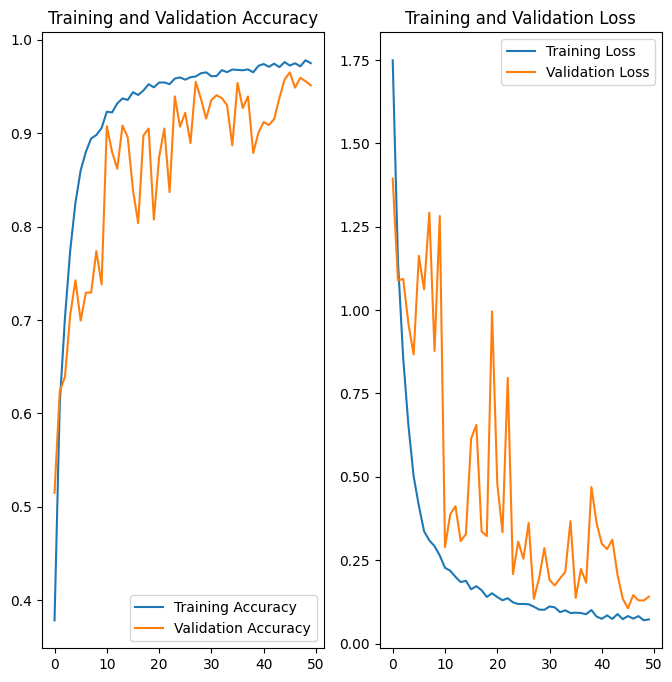

In [25]:
# Training and Validation Accuracy chart
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Training and Validation Loss chart (error )
plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

frist Image to predict
Label: Tomato_healthy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
Model prediction: Tomato_healthy


2024-07-31 14:48:32.375452: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


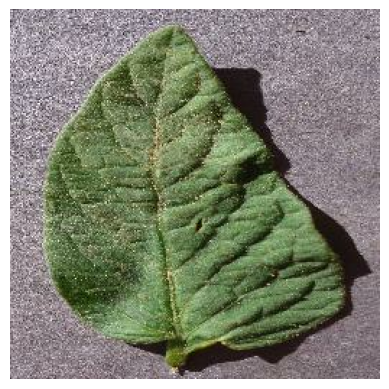

In [26]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("frist Image to predict")
    plt.imshow(first_image)
    print("Label:", class_names[first_label])
    
    bach_prediction = model.predict(images_batch)
    print("Model prediction:", class_names[np.argmax(bach_prediction[0])])
    plt.axis('off')

In [27]:
def predict(model, img):
    
    # img_array = tf.keras.img_to_array(img[i].numpy())
    img_array = tf.expand_dims(img, axis=0)
    
    predictions = model.predict(img_array)
    
    predicted_label = class_names[np.argmax(predictions[0])]
    confidence = (np.max(predictions[0]) * 100).round(2)
    
    return predicted_label, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


2024-07-31 14:48:33.126459: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


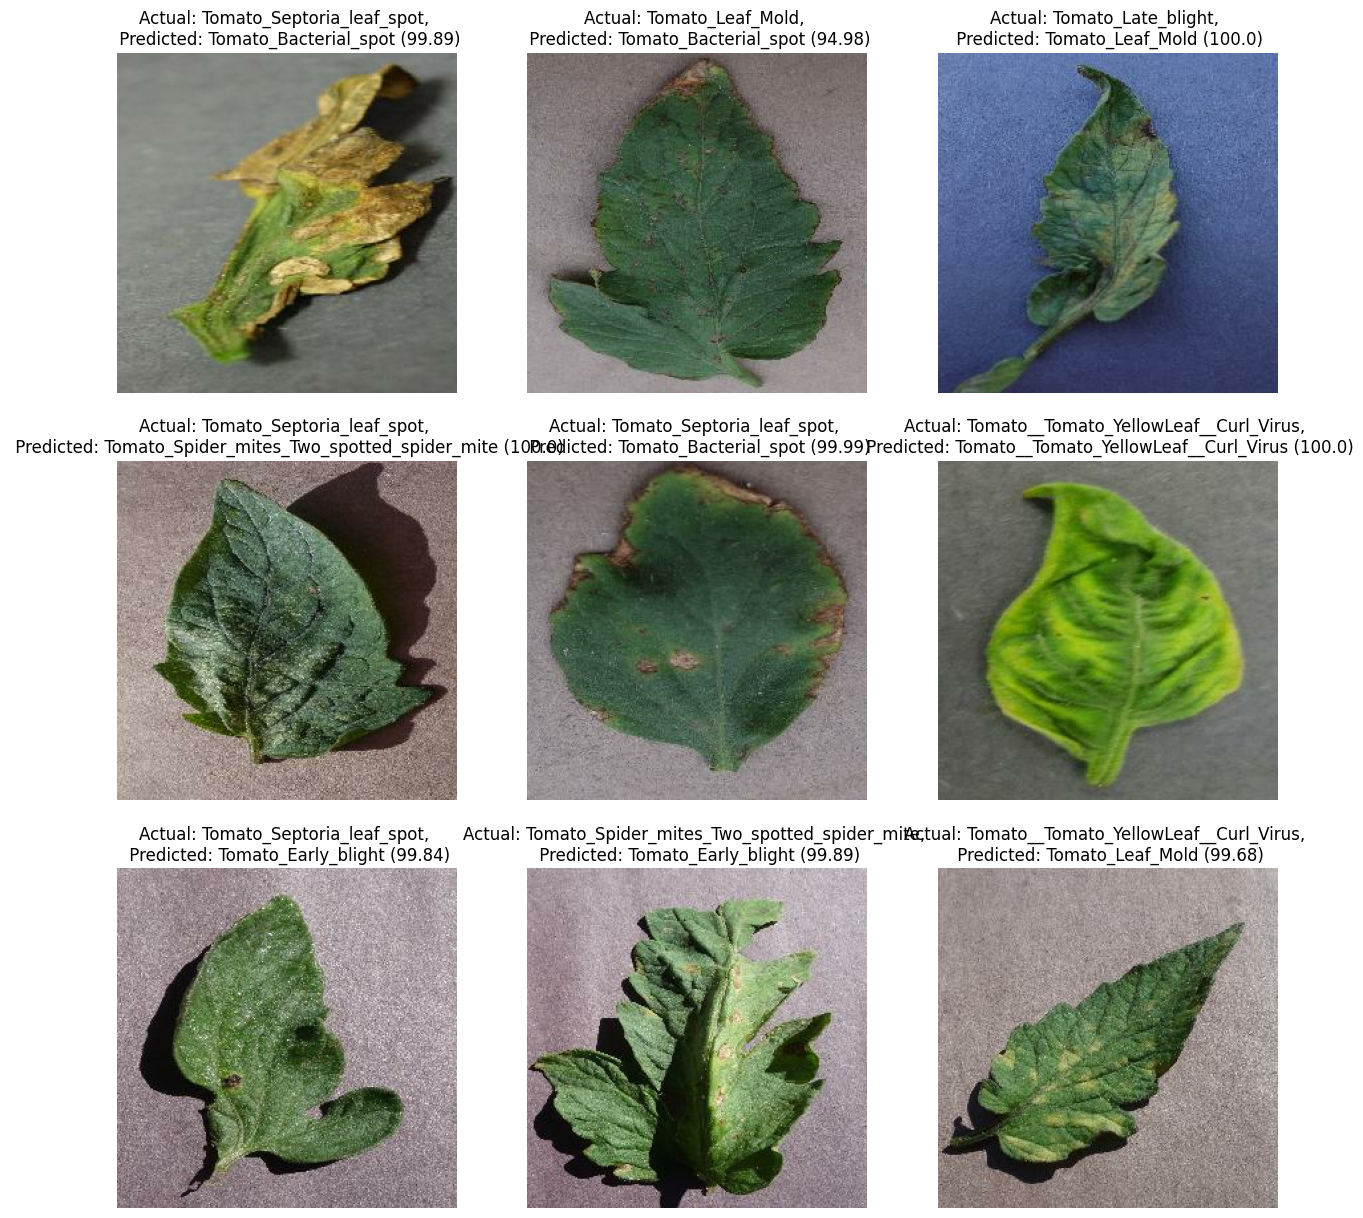

In [28]:
plt.figure(figsize=(15, 15))
for imges ,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_label, confidence = predict(model, images[i])
        actual_class = class_names[labels[i]]
        
        plt.title(f'Actual: {actual_class}, \n Predicted: {predicted_label} ({confidence})')
        plt.axis('off')

In [30]:
# model_version = 1
# model.save(f'/model/{model_version}')

model_version = 1
model.save(f'./model/{model_version}.keras')
